In [1]:
%load_ext autoreload
import networkx as nx
import matplotlib.pyplot as plt
import bpy
from bpy.types import bpy_prop_array
import mathutils

In [2]:
import sys
sys.path.append('/Users/orenm/BlenderShaderProject/project_files/')

In [3]:
%autoreload 2
from Logic.node_readers_writers import *

In [125]:
from collections import defaultdict

class NetworkManager(object):
    NODE_TYPES = ['CombineXYZ', 'Mapping',
    'Math', 'MixFloat', 'MixVector', 'SeparateXYZ', 'TexCoord', 'TexGabor', 'TexGradient',
    'TexNoise', 'TexVoronoiF', 'TexWave', 'ValToRGB', 'Value', 'VectorMath']
    NODE_TYPES = {name: globals()[name] for name in NODE_TYPES if name in globals()}
    
    def __init__(self):
        self.network = nx.MultiDiGraph()
        self.nodes = defaultdict(int)    
    
    def add_node(self, node_type_name):
        self.nodes[node_type_name] += 1
        node_name = node_type_name + f'_{self.nodes[node_type_name]}'
        node_type = self.NODE_TYPES[node_type_name]
        properties = {'numeric': {key: param.default for key, param in node_type.NUMERIC.items()},
                     'categorical': {key: param.default for key, param in node_type.CATEGORICAL.items()}}
        # properties.update({key: param.default for key, param in node_type.CATEGORICAL.items()})
        # properties.update({key: param.default for key, param in node_type.NUMERIC.items()})
        self.network.add_node(node_name, **properties)
        return node_name

    def add_edge(self, node1, node2, out1, in2):
        nm.network.add_edge(node1, node2, **{'out': out1, 'in': in2}, key=in2)
        # old_attr = nm.network.nodes()[node2][in2]
        # nx.set_node_attributes(nm.network, {node2:{in2: f'INPUT_{old_attr}'}})

    def remove_edge(self, node1, node2, in2):
        nm.network.remove_edge(node1, node2, key=in2)
        # old_attr = nm.network.nodes()[node2][in2]
        # nx.set_node_attributes(nm.network, {node2: {in2: eval(old_attr.replace('INPUT_', ''))}})

    def to_my_node(self, node_name):
        node_type = NODE_TYPES[node_name]
        node_data = nm.network.nodes()[node_name]
        input_data = [x[2]['in'] for x in nm.network.in_edges(node_name, data=True)]
        return node_type(input_data, node_data['numeric'], node_data['categorical']) 

In [126]:
nm = NetworkManager()

In [127]:
outputs = nm.NODE_TYPES['TexNoise'].OUTPUTS

In [128]:
inputs = nm.NODE_TYPES['TexNoise'].get_inputs()

In [129]:
out1 = list(outputs)[0]
in2 = list(inputs)[0]

In [130]:
node1 = nm.add_node('TexVoronoiF')
node2 = nm.add_node('TexVoronoiF')

In [131]:
nm.add_edge(node1, node2, out1, in2)

In [102]:
nm.network.nodes()['TexVoronoiF_2']

{'numeric': {'Vector': (0, 0, 0), 'Scale': 5, 'Randomness': 1},
 'categorical': {'distance': 'EUCLIDEAN'}}

In [103]:
list(nm.network.predecessors('TexVoronoiF_2'))

['TexVoronoiF_1']

In [110]:
nm.network.in_edges(node2, data=True)

InMultiEdgeDataView([('TexVoronoiF_1', 'TexVoronoiF_2', {'out': 'Color', 'in': 'Vector'})])

In [105]:
nm.network.edges['TexVoronoiF_1', 'TexVoronoiF_2', in2]

{'out': 'Color', 'in': 'Vector'}

In [119]:
node_data = nm.network.nodes()[node2]
input_data = [x[2]['in'] for x in nm.network.in_edges(node2, data=True)]

In [122]:
tex_node = TexVoronoiF(input_data, node_data['numeric'], node_data['categorical'])

In [73]:
nm.remove_edge(node1, node2, in2)

In [74]:
nm.network.nodes()['TexVoronoiF_2']

{'distance': 'EUCLIDEAN', 'Vector': (0, 0, 0), 'Scale': 5, 'Randomness': 1}

In [ ]:
# initialize a network from start to end or end to start
# just randomly connect some
# verify complete network
# randomize values of node

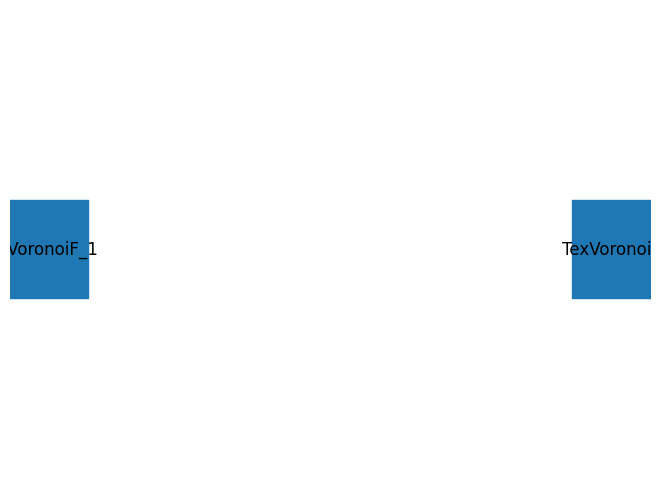

In [64]:
#try draw_spectral, draw_planar, draw_spring
nx.draw_planar(nm.network, with_labels=True, node_size=5000, node_shape='s')